In [1]:
# https://github.com/ray-project/ray/blob/master/rllib/examples/sb2rllib_rllib_example.py
import ray
from ray import tune, air
import ray.rllib.algorithms.ppo as ppo
from IPython.display import display, clear_output
from time import sleep
from glob import glob
from pathlib import Path
from tqdm import tqdm
from itertools import count
import matplotlib.pyplot as plt

In [2]:
if ray.is_initialized():
    ray.shutdown()
ray.init(num_gpus=1, local_mode=False)

Usage stats collection is enabled by default for nightly wheels. To disable this, run the following command: `ray disable-usage-stats` before starting Ray. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.


2023-02-25 20:10:13,902	INFO worker.py:1536 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.15
Ray version:,3.0.0.dev0
Dashboard:,http://127.0.0.1:8265


In [3]:
# env config
import gymnasium as gym
import platoonenv

env_name = "Platoon-v6"
env_config=dict(
    num_vehicles=10,
    steps_before_truncation=200,
    cycle_interval=2,
    attack_interval=1,
    cycle_num=1,
)
env = gym.make(
    id=env_name,
    render_mode="canvas",
    env_config=env_config,
)

print(env_name,"\n------------------")
print("reward_threshold", env.spec.reward_threshold)
print("max_episode_steps", env.spec.max_episode_steps)

Platoon-v6 
------------------
reward_threshold None
max_episode_steps None


In [4]:
from ray.rllib.utils import check_env

check_env(env)

2023-02-25 20:10:17,647	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.


In [5]:
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.dqn import DQNConfig
from ray.rllib.algorithms.random_agent import RandomAgentConfig

ppo_config = (
    PPOConfig()
    .environment(env=env_name, env_config=env_config)
    .framework("torch")
    .rollouts(num_rollout_workers=3)
    .resources(num_gpus=1, num_cpus_for_local_worker=0.5)
)

ppo_config.horizon = env.spec.max_episode_steps
ppo_config.create_env_on_local_worker=True

dqn_config = (
    DQNConfig()
    .environment(env=env_name, env_config=env_config)
    .framework("torch")
    .rollouts(num_rollout_workers=3)
    .resources(num_gpus=0.5, num_cpus_for_local_worker=0.5)
)
dqn_config.horizon = env.spec.max_episode_steps
dqn_config.create_env_on_local_worker=True

random_config = (
    RandomAgentConfig()
    .environment(env=env_name, env_config=env_config)
    .framework("torch")
    .rollouts(num_rollout_workers=3)
    .resources(num_gpus=0.5, num_cpus_for_local_worker=0.5)
)
random_config.horizon = env.spec.max_episode_steps
random_config.create_env_on_local_worker=True

In [6]:
ppo_algo = ppo_config.build()

(RolloutWorker pid=25004) 2023-02-25 20:10:27,558	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-02-25 20:10:27,687	INFO policy.py:1196 -- Policy (worker=local) running on 1 GPUs.
2023-02-25 20:10:27,688	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
(RolloutWorker pid=16180) 2023-02-25 20:10:27,631	INFO policy.py:1196 -- Policy (worker=3) running on CPU.
(RolloutWorker pid=16180) 2023-02-25 20:10:27,631	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
(RolloutWorker pid=17028) 2023-02-25 20:10:27,630	INFO policy.py:1196 -- Policy (worker=2) running on CPU.
(RolloutWorker pid=17028) 2023-02-25 20:10:27,630	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
(RolloutWorker pid=25004) 2023-02-25 20:10:27,629	INFO policy.py:1196 -- Policy (worker=1) running on 

In [7]:
!ray status

======== Autoscaler status: 2023-02-25 20:10:28.092398 ========
Node status
---------------------------------------------------------------
Healthy:
 1 node_0add2aaa105ebf7d247df7f86ec171595653bf4e9b8d02cba4d35e56
Pending:
 (no pending nodes)
Recent failures:
 (no failures)

Resources
---------------------------------------------------------------
Usage:
 3.0/12.0 CPU
 0.0/1.0 GPU
 0.0/1.0 accelerator_type:G
 0.00/11.117 GiB memory
 0.00/5.558 GiB object_store_memory

Demands:
 (no resource demands)


In [8]:
dqn_algo = dqn_config.build()

(RolloutWorker pid=4508) 2023-02-25 20:10:42,489	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-02-25 20:10:42,658	INFO policy.py:1196 -- Policy (worker=local) running on 0.5 GPUs.
2023-02-25 20:10:42,659	INFO torch_policy.py:184 -- Found 1 visible cuda devices.
(RolloutWorker pid=4508) 2023-02-25 20:10:42,549	INFO policy.py:1196 -- Policy (worker=1) running on CPU.
(RolloutWorker pid=4508) 2023-02-25 20:10:42,549	INFO torch_policy.py:184 -- Found 1 visible cuda devices.
(RolloutWorker pid=22800) 2023-02-25 20:10:42,580	INFO policy.py:1196 -- Policy (worker=3) running on CPU.
(RolloutWorker pid=22800) 2023-02-25 20:10:42,580	INFO torch_policy.py:184 -- Found 1 visible cuda devices.
(RolloutWorker pid=3092) 2023-02-25 20:10:42,623	INFO policy.py:1196 -- Policy (worker=2) running on CPU.
(Rollo

In [9]:
!ray status

======== Autoscaler status: 2023-02-25 20:10:43.119447 ========
Node status
---------------------------------------------------------------
Healthy:
 1 node_0add2aaa105ebf7d247df7f86ec171595653bf4e9b8d02cba4d35e56
Pending:
 (no pending nodes)
Recent failures:
 (no failures)

Resources
---------------------------------------------------------------
Usage:
 6.0/12.0 CPU
 0.0/1.0 GPU
 0.0/1.0 accelerator_type:G
 0.00/11.117 GiB memory
 0.00/5.558 GiB object_store_memory

Demands:
 (no resource demands)


In [10]:
random_algo = random_config.build()

In [11]:
!ray status

======== Autoscaler status: 2023-02-25 20:10:48.132908 ========
Node status
---------------------------------------------------------------
Healthy:
 1 node_0add2aaa105ebf7d247df7f86ec171595653bf4e9b8d02cba4d35e56
Pending:
 (no pending nodes)
Recent failures:
 (no failures)

Resources
---------------------------------------------------------------
Usage:
 6.0/12.0 CPU
 0.0/1.0 GPU
 0.0/1.0 accelerator_type:G
 0.00/11.117 GiB memory
 0.00/5.558 GiB object_store_memory

Demands:
 (no resource demands)


In [12]:
checkpoints = sorted(glob(str(Path("saved_models","**","checkpoint_*"))))

In [13]:
import ipywidgets as widgets

In [14]:
def dirs_only(paths):
    return [path for path in paths if Path(path).is_dir()]

In [15]:
suffix = "grow-1"
ppo_save_dir = Path("saved_models",f"{env_name}-{str(ppo_algo)}-{env_config['num_vehicles']}vehicles-{suffix}")
ppo_save_dir.mkdir(parents=True, exist_ok=True)
print(ppo_save_dir)

ppo_checkpoint_path = sorted(dirs_only(glob(str(ppo_save_dir / "*"))))[-1] # grab latest

w = widgets.Dropdown(
    layout={'width': 'initial'},
    options=checkpoints,
    value=ppo_checkpoint_path,
    description='PPO:'
)

def on_change(change):
    global ppo_checkpoint_path
    if change['type'] == 'change' and change['name'] == 'value':
        print("changed to %s" % change['new'])
        ppo_checkpoint_path = change['new']

w.observe(on_change)
display(w)

saved_models\Platoon-v6-PPO-10vehicles-grow-1


Dropdown(description='PPO:', index=112, layout=Layout(width='initial'), options=('saved_models\\Platoon-v0-cur…

In [16]:
suffix="grow-1"
dqn_save_dir = Path("saved_models",f"{env_name}-{str(dqn_algo)}-{env_config['num_vehicles']}vehicles-{suffix}")
dqn_save_dir.mkdir(parents=True, exist_ok=True)
print(dqn_save_dir)

dqn_checkpoint_path = sorted(dirs_only(glob(str(dqn_save_dir / "*"))))[-1] # grab latest

w = widgets.Dropdown(
    layout={'width': 'initial'},
    options=checkpoints,
    value=dqn_checkpoint_path,
    description='DQN:'
)

def on_change(change):
    global dqn_checkpoint_path
    if change['type'] == 'change' and change['name'] == 'value':
        print("changed to %s" % change['new'])
        dqn_checkpoint_path = change['new']

w.observe(on_change)
display(w)

saved_models\Platoon-v6-DQN-10vehicles-grow-1


Dropdown(description='DQN:', index=62, layout=Layout(width='initial'), options=('saved_models\\Platoon-v0-curi…

In [17]:
print(f"PPO restoring from checkpoint: {ppo_checkpoint_path}")
ppo_algo.restore(ppo_checkpoint_path)

PPO restoring from checkpoint: saved_models\Platoon-v6-PPO-10vehicles-grow-1\checkpoint_000335


2023-02-25 20:10:49,758	INFO trainable.py:790 -- Restored on 127.0.0.1 from checkpoint: saved_models\Platoon-v6-PPO-10vehicles-grow-1\checkpoint_000335
2023-02-25 20:10:49,760	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 335, '_timesteps_total': None, '_time_total': 3606.120593070984, '_episodes_total': 17414}


In [18]:
print(f"DQN restoring from checkpoint: {dqn_checkpoint_path}")
dqn_algo.restore(dqn_checkpoint_path)

2023-02-25 20:10:49,872	INFO trainable.py:790 -- Restored on 127.0.0.1 from checkpoint: saved_models\Platoon-v6-DQN-10vehicles-grow-1\checkpoint_000578
2023-02-25 20:10:49,873	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 578, '_timesteps_total': None, '_time_total': 3604.257714033127, '_episodes_total': 11637}


DQN restoring from checkpoint: saved_models\Platoon-v6-DQN-10vehicles-grow-1\checkpoint_000578


In [19]:
{
    "ppo":{k:v for k,v in ppo_algo.get_state().items() if k != "last_result"},
    "dqn": {k:v for k,v in dqn_algo.get_state().items() if k != "last_result"},
}

{'ppo': {'experiment_id': 'c155813fd6d94d078a37dccebb18442d',
  'iteration': 335,
  'timesteps_total': None,
  'time_total': 3606.120593070984,
  'episodes_total': 17414,
  'ray_version': '3.0.0.dev0'},
 'dqn': {'experiment_id': '14dfddefe5ca4ede8ce91fab72341066',
  'iteration': 578,
  'timesteps_total': None,
  'time_total': 3604.257714033127,
  'episodes_total': 11637,
  'ray_version': '3.0.0.dev0'}}

In [20]:
# iter = dqn_algo.get_state()["iteration"]
# assert dqn_algo.get_state()["iteration"] == ppo_algo.get_state()["iteration"]

In [21]:
import numpy as np

In [22]:
%matplotlib ipympl

In [23]:
env = gym.make(
    id=env_name,
    render_mode="canvas",
    env_config=env_config
)

In [24]:
# suffix = "iter" + dqn_algo.get_state()["iteration"]
suffix = "grow-1"
figure_save_dir = Path("figures", f"{env_name}-{str(dqn_algo)}-{env_config['num_vehicles']}vehicles-{suffix}")
figure_save_dir.mkdir(parents=True, exist_ok=True)
print(f"saving to \"{figure_save_dir}\"")

saving to "figures\Platoon-v6-DQN-10vehicles-grow-1"


In [27]:
from IPython.display import display, clear_output
from ipycanvas import Canvas
obs, info = env.reset(seed=0)
for i in count():
    action = ppo_algo.compute_single_action(obs)
    next_obs, reward, done, trunc, info = env.step(action)
    obs = next_obs
    # clear_output()
    # display(env.render())
    if done or trunc:
        break
# display(env.render())
canvas: Canvas = env.render()
display(canvas)

Canvas(height=1480, width=1210)

In [ ]:
# find the first index of a zero and add 1, or return 0 otherwise
def find_first_zero(x):
    try:
        return np.where(x==0)[0][0] + 1
    except IndexError:
        return 0

In [ ]:
policies = {
    "PPO": lambda obs, info: ppo_algo.compute_single_action(obs, explore=True),
    "DQN": lambda obs, info: dqn_algo.compute_single_action(obs, explore=True),
    "random": lambda obs, info: env.action_space.sample(),
    "no-op": lambda obs, info: 0,
    "grow": lambda obs, info: find_first_zero(info["members"]),
}

In [ ]:
history = {}

In [ ]:
num_episodes = 100
with tqdm(total=env_config["steps_before_truncation"]*len(policies)*num_episodes) as pbar:
    for policy_name, policy in policies.items():
        pbar.set_description(policy_name)
        episodes = []
        for episode in range(num_episodes):
            actions = []
            rewards = []
            observations = []
            infos = []
            obs, info = env.reset(seed=episode+10)
            observations.append(obs)
            infos.append(info)
            for episode_step in count():
                pbar.update()
                action = policy(obs, info)
                next_obs, reward, terminated, truncated, info = env.step(action)
                actions.append(action)
                rewards.append(float(reward))
                observations.append(next_obs)
                infos.append(info)
                if terminated or truncated:
                    break
                obs = next_obs
            episodes.append({
                "actions": actions,
                "rewards": rewards,
                "observations": observations,
                "infos": infos,
                "length": episode_step + 1,
            })
        history[policy_name] = episodes


NameError: name 'tqdm' is not defined

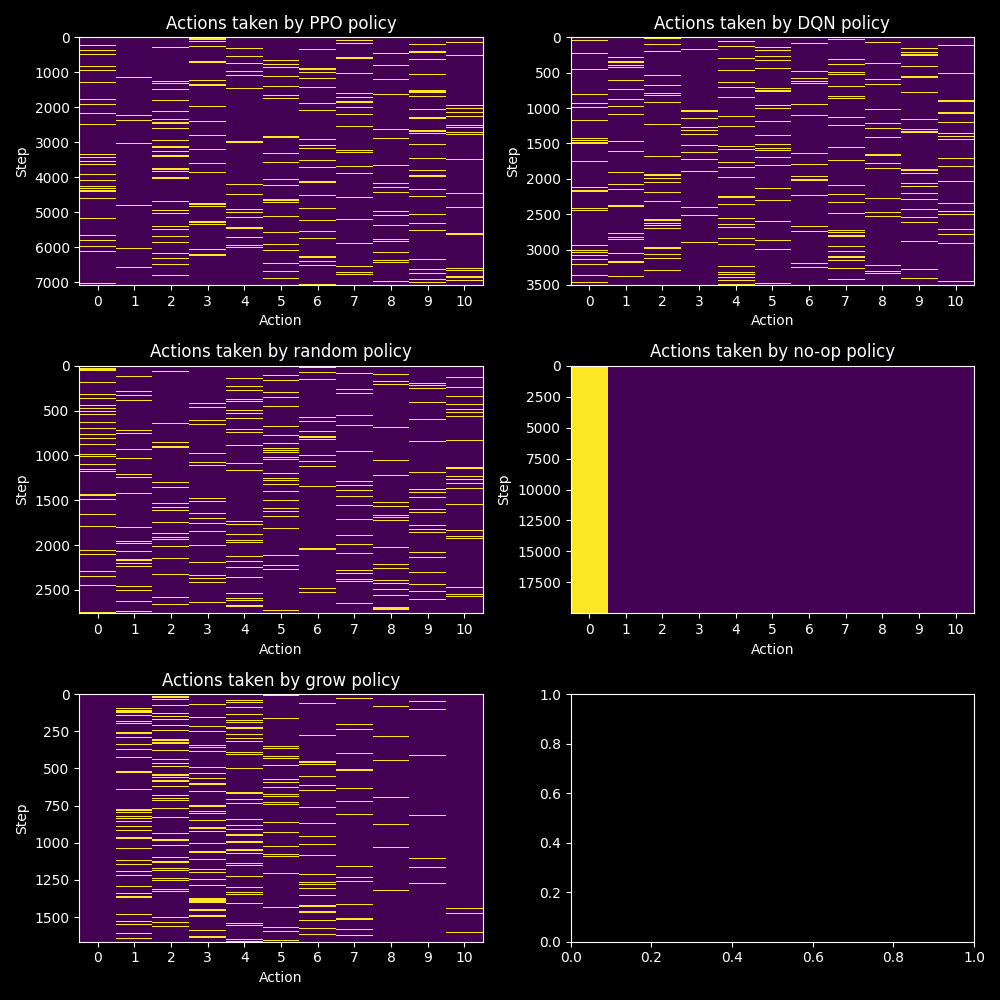

In [ ]:
from keras.utils.np_utils import to_categorical

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))
for i, (policy_name, episodes) in enumerate(history.items()):
    ax = axes[i//2, i%2]
    ax.set_title(f"Actions taken by {policy_name} policy")
    actions = to_categorical(np.concatenate([e["actions"] for e in episodes]), num_classes=env.action_space.n)
    ax.imshow(actions, interpolation="nearest", aspect="auto")
    ax.set_xlabel("Action")
    ax.set_ylabel("Step")
    if num_episodes <= 25:
        for y in np.cumsum([e["length"] for e in episodes]):
            ax.axhline(y, color="white", alpha=0.2, linewidth=0.5)
    ax.set_xticks(np.arange(0,11,1))
    # ax.grid(alpha=0.1)
plt.tight_layout()
plt.savefig(figure_save_dir / f"actions.png", format="png", dpi=300, bbox_inches="tight")

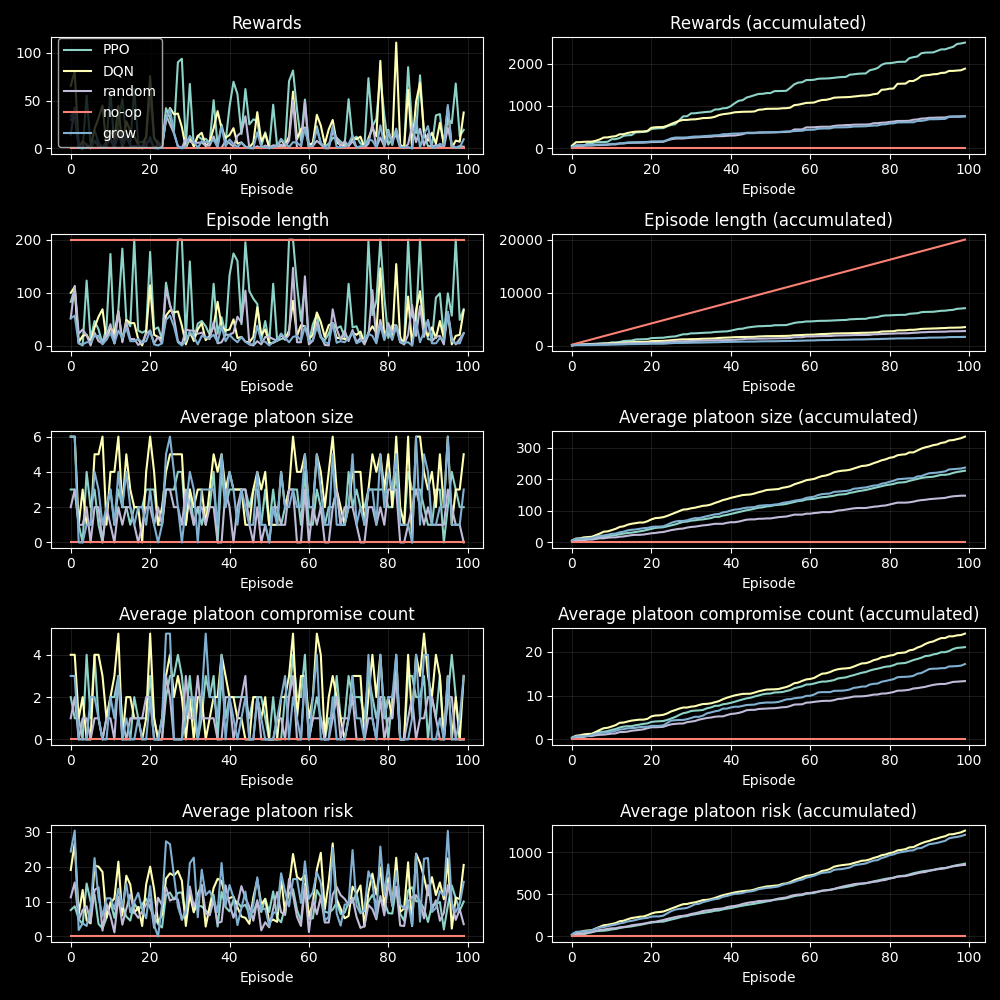

In [ ]:
from statistics import mean


metrics = {
    "rewards": lambda episodes: [sum(e["rewards"]) for e in episodes],
    "rewards (accumulated)": lambda episodes: np.cumsum([sum(e["rewards"]) for e in episodes]),
    "episode length": lambda episodes: [e["length"] for e in episodes],
    "episode length (accumulated)": lambda episodes: np.cumsum([e["length"] for e in episodes]),
    "average platoon size": lambda episodes: [mean((info["members"]==1).sum() for info in e["infos"]) for e in episodes],
    "average platoon size (accumulated)": lambda episodes: np.cumsum([mean((info["members"]==1).sum() for info in e["infos"]) for e in episodes]),
    "average platoon compromise count": lambda episodes: [
        mean(
            ((info["probs"] == 1)*(info["members"]==1)[:,None]).sum()
            for info in e["infos"]
        )
        for e in episodes
    ],
    "average platoon compromise count (accumulated)": lambda episodes: np.cumsum([
        mean(
            ((info["probs"] == 1)*(info["members"]==1)[:,None]).sum(axis=1).mean()
            for info in e["infos"]
        )
        for e in episodes
    ]),
    "average platoon risk": lambda episodes: [
        mean(
            ((info["members"]==1)[:,None]*info["severities"]).sum()
            for info in e["infos"]
        )
        for e in episodes   
    ],
    "average platoon risk (accumulated)": lambda episodes: np.cumsum([
        mean(
            ((info["members"]==1)[:,None]*info["severities"]).sum()
            for info in e["infos"]
        )
        for e in episodes   
    ]),
}

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,10))
for i, (metric, measure) in enumerate(metrics.items()):
    ax = axes[i//2, i%2]
    for j, (policy_name, episodes) in enumerate(history.items()):
        ax.plot(measure(episodes), label=policy_name, alpha=1)   
    ax.set_title(f"{metric.capitalize()}")
    ax.set_xlabel("Episode")
    # ax.set_xticks(np.arange(0,num_episodes,1))
    if i == 0:
        ax.legend()
    ax.grid(alpha=0.1)
plt.tight_layout()
plt.savefig(figure_save_dir / f"metrics.png", format="png", dpi=300, bbox_inches="tight")

In [ ]:
keep = {k: v for k, v in metrics.items() if "accumulated" not in k}
print(r"\begin{tabular}{" + r"|p{2cm}"*(len(keep)+1) + "|}\n\\hline")
print("policy", end=" & ")
for i,metric in enumerate(keep.keys()):
    print(metric.capitalize(), end=" & " if i+1 != len(keep) else "\\\\")
print("\n\\hline")
for policy, episodes in history.items():
    print(policy, end=" & ")
    for i,metric in enumerate(keep.values()):
        print(f"{np.mean(metric(episodes)):.3f}", end=" & " if i+1 != len(keep) else "\\\\")
    print()

\begin{tabular}{|p{2cm}|p{2cm}|p{2cm}|p{2cm}|p{2cm}|p{2cm}|}
\hline
policy & Rewards & Episode length & Average platoon size & Average platoon compromise count & Average platoon risk\\
\hline
PPO & 24.924 & 70.750 & 2.270 & 1.640 & 8.638\\
DQN & 18.793 & 35.030 & 3.350 & 1.980 & 12.558\\
random & 7.590 & 27.630 & 1.480 & 0.920 & 8.489\\
no-op & 0.000 & 200.000 & 0.000 & 0.000 & 0.000\\
grow & 7.553 & 16.660 & 2.370 & 1.280 & 12.061\\
